***
<p style="text-align:left;">Reinforcement Learning
<span style="float:right;">Monday, 11. May 2020</span></p>

<p style="text-align:left;">Prof. S. Harmeling
<span style="float:right;">DUE 23:55 Monday, 18. May 2020</span></p>

---
<p style="text-align:center;"><b>Exercise set #4</b></p>

---

# 3. Monte Carlo control

In this exercise you will implement the **Monte Carlo control** algorithm.  
This exercise was inspired by the Reinforcement Learning tutorial by Shimon Whiteson  
from the Machine Learning Summer School 2019: https://github.com/mlss-skoltech

Monte Carlo (MC) methods are used on episodic tasks where the model is not known (model-free).  
The algorithm learns the perfect policy from experience by averaging the sample returns at the end of each episode. 

In the last exercise we had a perfect model of the FrozenLake environment, where all the transition probabilities between states are defined.  
In constrast to this, MC methods learn the probability distributions by generating sample transitions over many episodes.

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Blackjack Environment

In this exercise we will work with the **Blackjack** environment from OpenAI's gym library.  

### Blackjack rules (according to OpenAI)

*Blackjack is a card game where the goal is to obtain cards that sum to as
 near as possible to 21 without going over.  They're playing against a fixed dealer.*
    
*Face cards (Jack, Queen, King) have point value 10.
Aces can either count as 11 or 1, and it's called 'usable' at 11.
This game is placed with an infinite deck (or with replacement).
The game starts with each (player and dealer) having one face up and one
face down card.*

*The player can request additional cards (hit=1) until they decide to stop
(stick=0) or exceed 21 (bust).*

*After the player sticks, the dealer reveals their facedown card, and draws
until their sum is 17 or greater.  If the dealer goes bust the player wins.
If neither player nor dealer busts, the outcome (win, lose, draw) is
decided by whose sum is closer to 21.  The reward for winning is +1,
drawing is 0, and losing is -1.*

*The observation of a 3-tuple of: the players current sum,
the dealer's one showing card (1-10 where 1 is ace),
and whether or not the player holds a usable ace (0 or 1).*

This environment corresponds to the version of the blackjack problem
described in Example 5.1 in  
[Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html) by Sutton and Barto.

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).


The agent has two potential actions:
```
    STICK = 0,        
    HIT = 1,
```
Verify this by running the code cell below:

In [2]:
env = gym.make('Blackjack-v0')
env.reset()

(17, 8, False)

Print the observation space and action space of the environment to see if it matches the description above:

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


## Policies

In our setup, policies are functions that take two arguments, ```env``` and ```state```, and return an action based on that state:

```
def my_policy(env, state):
    action = ...
    return action
```

In [53]:
def policy_simulation_mc(env, policy, num_episodes=1, silent=True, only_last=False):
    """Simulates episodes of the blackjack environment for a given policy.
        
        Args:
            env (object): An instance of a blackjack environment.
            policy (callable): A function that takes an environment and state and returns an action.
            num_episodes (int): Number of episodes to return.
            silent (bool): If true supress output.
            only_last (bool): If true only return last triple for each episode.
            
        Returns:
            episodes (list): List of triples (state, action, reward) encountered during the episodes.
        """
    episodes = []
    for i_episode in range(num_episodes):
        state = env.reset()
        done = False
        while not done:            
            action = policy(env, state)
            if not silent:
                print("state:", state)
                if action == 0:
                    print('STICK')
                else:
                    print('HIT')
            next_state, reward, done, info = env.step(action)
            if not only_last:
                episodes.append((state, action, reward))
            state = next_state   
        
        if only_last:
            episodes.append((state, action, reward))
        
        if not silent:
            print('End game! Reward:', reward)
            if reward > 0:
                print('You won :) (lucky you)\n')  
            elif reward == 0:
                print('A draw! (lucky you)\n')  
            else:
                print('You lost :( (gambling is a bad habit anyway)\n')
    
    return episodes

### Random policy

We use the random policy to test the policy simulation:

In [52]:
def random_policy(env, state):
    return env.action_space.sample()

In [12]:
policy_simulation_mc(env, random_policy, num_episodes=3, silent=False)

0
state: (21, 6, True)
STICK
End game! Reward: 1.0
You won :) (lucky you)

1
state: (16, 3, False)
HIT
1
state: (19, 3, False)
HIT
End game! Reward: -1
You lost :( (gambling is a bad habit anyway)

0
state: (20, 1, False)
STICK
End game! Reward: -1.0
You lost :( (gambling is a bad habit anyway)



[((21, 6, True), 0, 1.0),
 ((16, 3, False), 1, 0),
 ((19, 3, False), 1, -1),
 ((20, 1, False), 0, -1.0)]

### Stochastic policy

Let us investigate a particular policy that may lead us to victory.  
What if each time the sum of our cards gets $> 18$, we STICK, and if this sum is $\leq 18$ we hit and ask for more cards?  

Implement a policy that follows this procedure $80\%$ of the time and $20\%$ of the time does the opposite:

In [21]:
def limit_stochastic_policy(env, state):
    probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
    return np.random.choice(np.arange(2), p=probs)

In [22]:
policy_simulation_mc(env, limit_stochastic_policy, num_episodes=3, silent=False)

state: (10, 4, False)
HIT
state: (19, 4, False)
STICK
End game! Reward: 1.0
You won :) (lucky you)

state: (17, 2, False)
HIT
End game! Reward: -1
You lost :( (gambling is a bad habit anyway)

state: (15, 10, False)
HIT
state: (16, 10, False)
HIT
state: (18, 10, False)
HIT
End game! Reward: -1
You lost :( (gambling is a bad habit anyway)



[((10, 4, False), 1, 0),
 ((19, 4, False), 0, 1.0),
 ((17, 2, False), 1, -1),
 ((15, 10, False), 1, 0),
 ((16, 10, False), 1, 0),
 ((18, 10, False), 1, -1)]

## Monte Carlo control

Since the states constist of tuples, we won't be able to just store the action-values in a 2D array. Therefore we will store them in a ```dict``` instead,  
with the states as keys and the corresponding action-values as values, i.e. ```Q[s]``` is a numpy array and s is a tuple.  
In the following we will call such a dictionary a *Q-table*.

We start with an arbitrary Q-table and compute the corresponding policy. We can improve upon our existing policy by just greedily choosing the  
best action at each state as per our knowledge, i.e. the Q-table, and then recomputing the Q-table. Then we repeat this process over and over again.

However, we will now face:
- Exploration-exploitation problem ($\epsilon$-greedy policy)
- Decreasing an incremental change term (use a constant hyperparameter instead) (i.e. change $1/N$ to some $\alpha$)

Your task is to implement a variant of the following algorithm and to apply it to the blackjack environment:

<img src="https://github.com/mlss-skoltech/tutorials_week2/raw/master/reinforcement_learning/img/monte_carlo_off.png" width="500" height="473">

First you will need to implement the following function to obtain a policy from a Q-table.  
Look at (c) from the algorithm above.

In [32]:
def policy_from_Q(Q, epsilon):
    """Computes an epsilon-greedy policy for a Q-table.
    
        Args:
            Q (dict): The Q-table. It may or may not have an entry for every state.
            epsilon (float): The epsilon value.
        
        Returns:
            policy (callable): A function that takes an environment and state and returns an action.
    """
    
    def policy(env, state):
        if state not in Q:
            return env.action_space.sample()
        
        n = env.action_space.n
        probs = np.ones(n) * epsilon / n
        
        best_a = np.argmax(Q[state])
        
        probs[best_a] = 1 - epsilon + (epsilon / n)
        
        return np.random.choice(n, p=probs)
    
    return policy

Now implement the update function for the Q-table. Instead of saving all returns, take a moving average with rate $\alpha$:

In [33]:
def update_Q(episode, Q, alpha, gamma):
    """Updates the action-value function estimate using the most recent episode.
    
        Args:
            episode (list): List of triples (state, action, reward) encountered during the episodes.
            Q (dict): The current Q-table.
            alpha (float): The update factor.
            gamma (float): The reward discount factor.
        
        Returns:
            Q (dict): The updated Q-table.
    """
    states, actions, rewards = zip(*episode)
    
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    
    return Q

Now you can test your implementation:

In [34]:
def mc_control(env, num_episodes, generate_episode, alpha, gamma=1.0,
               eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    """Estimates an optimal policy using mc control"""
    
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    epsilon = eps_start
    for episode in range(1, num_episodes + 1):
        
        if episode % 1000 == 0:
            print('\rEpisode {}/{}'.format(episode, num_episodes), end='', flush=True)
        
        epsilon = max(epsilon * eps_decay, eps_min)
        
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode(env, policy_from_Q(Q, epsilon))
        
        # update the action-value function estimate using the episode
        Q = update_Q(episode, Q, alpha, gamma)
        
    # determine the policy corresponding to the final action-value function estimate
    policy = policy_from_Q(Q, 0)
    return policy

Let's run the algorithm to get the estimated optimal polciy:

In [26]:
mc_policy = mc_control(env, 500000, policy_simulation_mc, alpha=0.02)

Episode 500000/500000

In [35]:
policy_simulation_mc(env, mc_policy, num_episodes = 3, silent = False)

state: (12, 5, False)
HIT
End game! Reward: -1
You lost :( (gambling is a bad habit anyway)

state: (13, 5, False)
STICK
End game! Reward: 1.0
You won :) (lucky you)

state: (9, 2, False)
HIT
state: (13, 2, False)
STICK
End game! Reward: -1.0
You lost :( (gambling is a bad habit anyway)



[((12, 5, False), 1, -1),
 ((13, 5, False), 0, 1.0),
 ((9, 2, False), 1, 0),
 ((13, 2, False), 0, -1.0)]

Compare the Monte Carlo policy to the other policies by completing the function below:

In [43]:
def plot_wins(policies, num_episodes=10000):
    plt.figure()
    
    for i, (policy, name) in enumerate(policies):
        # data is a list containing one tiple (state, action, reward) from the end of each episode
        data = policy_simulation_mc(env, policy,  num_episodes=num_episodes, only_last=True)
        
        # compute the number of wins, draws and losses
        [_,_, rewards] = zip(*data)
        losses = rewards.count(-1.0)
        draws = rewards.count(0.0)
        wins = rewards.count(1.0)        
    
        plt.bar([1 + ((i - 1) / 4), 2 + ((i - 1) / 4), 3 + ((i - 1) / 4)],
                [losses, draws, wins], width=0.2, label=name)
    
    plt.legend()
    plt.xticks([1, 2, 3], ['losses', 'draws', 'wins'])

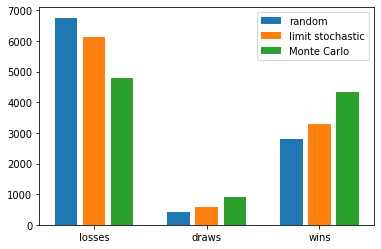

In [54]:
plot_wins([(random_policy, 'random'), (limit_stochastic_policy, 'limit stochastic'), (mc_policy, 'Monte Carlo')])

Let's take a look at how your policy behaves in different scenarios:

In [55]:
def plot_policy(env, policy):

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[policy(env, (x,y,usable_ace)) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

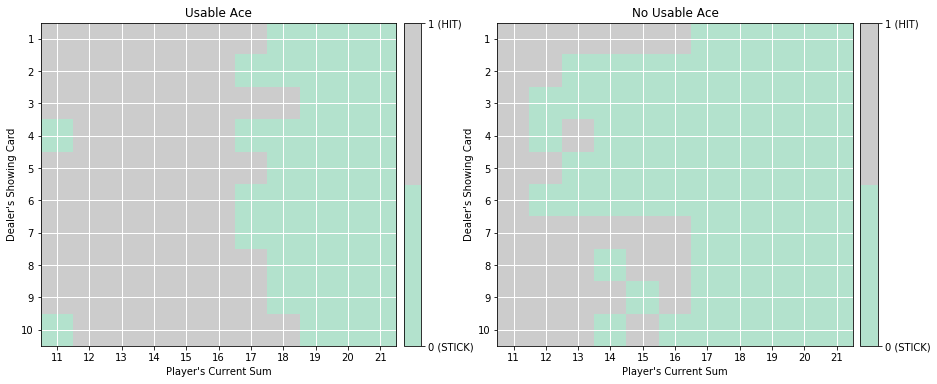

In [56]:
plot_policy(env, mc_policy)

And here is the true optimal policy $\pi_*$ that can be found in Figure 5.2 of [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html) by Sutton and Barto.  
Compare your final estimate to the optimal policy - how close are you able to get? If you are not happy with the performance of your algorithm,  
take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

<img src="https://github.com/mlss-skoltech/tutorials_week2/raw/master/reinforcement_learning/img/right_policy.png" width="700" height="573">